# Modeling with Synthetic Data generated by the Markov model

In [1]:
import sys
import os

# remember the original sys.path
original_sys_path = sys.path.copy()

try:
    base_path = os.getcwd()

    # ../stefan/ is used to import src
    target_path = os.path.abspath(os.path.join(base_path, '../stefan/'))
    sys.path.insert(0, target_path)
    from src import Flag, AbstractTask, AbstractFlag, Pipeline, plotMatrix, plotReport
    from src import plotMatrix, plotReport

finally:
    # sys.path must be restored to original sys.path
    sys.path = original_sys_path

import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataPath = r"../stefan/data/csv/"
MarkovdataPath = r"../data_for_markov_model/"
picklePath = r"../stefan/pickle_objects/modeling_pipeline/"
plotPath = r"../evaluation/confusion_matrix/"
tablePath = r"../evaluation/confusion_report/"
modelPath = r"../pickle_for_markov_model/"

In [3]:
# @author:
#    Stefan Richard Saxer

import pickle
with open(picklePath + 'Modeling Pipeline.pickle', 'rb') as f:
    ModelingPipeline = pickle.load(f)

ModelingPipeline.print(priority = True, flags = True)

Modeling Pipeline
	10 Pre Processing: Pre Processing
		10 Select and order columns
		20 Company ID and UUID
			10 Fill Company ID with None
			20 Fill UUID with None
			30 Replace Company IDs
			40 Replace Company UUIDs
		30 MS Data Processing
			10 Fill MS Data with empty String
			20 Length of MS Data
			30 Continuity Type
			40 Drop MS Data Column
		40 Service Data Processing
			10 Fill Service Data with empty String
			20 Length of Service Data
			30 Samsung Type
			40 Drop Service Data Column
		50 Fill Numeric NA with 0
		60 Fill String NA with None
		70 Datetime conversion
		80 Clean PDU
		90 Order DataFrame
		100 Convert object type to string
	20 Dummy Processing: Dummy Processing
		10 Dummies Channel
		20 Dummies AD Type
		30 Dummies Company
		40 Dummies UUID
		50 Dummies PDU Type
		60 Dummies Continuity Type
		70 Dummies SmartTag Type
	30 Labeling: Labeling
		10 Labeling auto: Labeling auto
			Label FindMy Tracker and iDevice: Label FindMy Tracker and iDevice
			Label Tile and

In [4]:
# @author:
#    Stefan Richard Saxer

with open(picklePath + 'Pre Processing.pickle', 'rb') as f:
    flag_preProcessing = pickle.load(f)

with open(picklePath +  'Modeling.pickle', 'rb') as f:
    flag_modeling = pickle.load(f)

with open(picklePath + 'Dummy Processing.pickle', 'rb') as f:
    flag_dummy= pickle.load(f)

with open(picklePath + 'Drop Columns.pickle', 'rb') as f:
    flag_dropColumns= pickle.load(f)

with open(picklePath + 'Label FindMy Tracker and iDevice.pickle', 'rb') as f:
    flag_label_FindMy_Tracker_and_iDevice = pickle.load(f)

with open(picklePath + 'Label FindMy Tracker.pickle', 'rb') as f:
    flag_label_FindMy_Tracker = pickle.load(f)

with open(picklePath + 'Label Tile and iDevice.pickle', 'rb') as f:
    flag_label_Tile_and_iDevice = pickle.load(f)

with open(picklePath + 'Label Tile.pickle', 'rb') as f:
    flag_label_Tile = pickle.load(f)

with open(picklePath + 'Label SmartTag and Other.pickle', 'rb') as f:
    flag_label_SmartTag_and_Other = pickle.load(f)

with open(picklePath + 'Label SmartTag.pickle', 'rb') as f:
    flag_label_SmartTag = pickle.load(f)

with open(picklePath + 'Label iDevice.pickle', 'rb') as f:
    flag_label_iDevice= pickle.load(f)

with open(picklePath + 'State lost.pickle', 'rb') as f:
    flag_state_lost = pickle.load(f)

with open(picklePath + 'State unpaired.pickle', 'rb') as f:
    flag_state_unpaired = pickle.load(f)

with open(picklePath + 'State nearby.pickle', 'rb') as f:
    flag_state_nearby = pickle.load(f)

with open(picklePath + 'States iDevices.pickle', 'rb') as f:
    flag_states_iDevices = pickle.load(f)

with open(picklePath + 'Drop iDevice.pickle', 'rb') as f:
    flag_drop_label_iDevice = pickle.load(f)

with open(picklePath + 'Drop other Device.pickle', 'rb') as f:
    flag_drop_label_Other = pickle.load(f)

with open(picklePath + 'Rate Modeling.pickle', 'rb') as f:
    flag_Rate_Modeling = pickle.load(f)

with open(picklePath + 'Label other Device.pickle', 'rb') as f:
    flag_label_other_Device = pickle.load(f)

with open(picklePath + 'Drop iDevice FindMy.pickle', 'rb') as f:
    flag_drop_label_iDevice_FindMy = pickle.load(f)

with open(picklePath + 'Label Unknown.pickle', 'rb') as f:
    flag_label_Unknown = pickle.load(f)

In [5]:
# @author:
#    Stefan Richard Saxer

from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def filesToDataFrame(filesDict: dict[str:AbstractFlag], filePath:str = dataPath, config:AbstractTask = ModelingPipeline, ) -> pd.DataFrame:
    dataset = pd.DataFrame()

    for f in filesDict.keys():
        new_dataset = Pipeline().setPath(filePath + f).setTask(config).loadData().run(flag=filesDict[f])
        dataset = pd.concat([dataset, new_dataset])

    dataset.reset_index(drop = True, inplace = True)

    return dataset

def prepareDataset(dataset:pd.DataFrame,  balance:bool = False, shuffle:bool = False, fraction:int = 1, labelColumn:str='Label') -> pd.DataFrame:
    if balance:
        min_count = dataset.groupby(labelColumn).size().min()
        dataset = dataset.groupby(labelColumn).sample(n = min_count*fraction, random_state=0).reset_index(drop = True)

    elif fraction < 1:
        dataset = dataset.sample(frac = fraction, random_state=0)

    if shuffle:
        dataset = dataset.sample(frac = 1, random_state=0)

    dataset.reset_index(drop = True, inplace = True)

    return dataset

def splitDataset(dataset:pd.DataFrame, dataset_unlabeled:pd.DataFrame = None, labelColumn:str ='Label'):
    Y = dataset[labelColumn]
    X = dataset.drop([labelColumn], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0, stratify = Y, shuffle = True)

    if not dataset_unlabeled is None:
        Y_unlabeled = unlabeledData[labelColumn]
        X_unlabeled = unlabeledData.drop(labelColumn, axis = 1)

        X_train = pd.concat([X_train, X_unlabeled])
        y_train = pd.concat([y_train, Y_unlabeled])

    X_train.reset_index(drop = True, inplace = True)
    X_test.reset_index(drop = True, inplace = True)

    return X_train, X_test, y_train, y_test

def scaleDataset(X_train: pd.DataFrame, X_test: pd.DataFrame, saveName:str = None):
    scaler = MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    saveScaler(scaler, saveName)

    return X_train, X_test, scaler


def saveModel(model, name: str, savePath:str = modelPath):
    if savePath is not None and name is not None:
        with open(savePath + name + ' model.pickle', 'wb') as f:
            pickle.dump(model, f)

def saveScaler(scaler, name:str, savePath:str = modelPath):
    if savePath is not None and name is not None:
        with open(savePath + name + ' scaler.pickle', 'wb') as f:
            pickle.dump(scaler, f)

def trainModel(X_train: pd.DataFrame,
                  X_test: pd.DataFrame,
                  y_train: pd.DataFrame,
                  y_test: pd.DataFrame,
                  model,
                  report:bool = True,
                  matrix:bool = True,
                  saveName:str = None):

    model = model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    if report or matrix:
        print("\n")

    if report:
        plotReport(y_test, y_test_pred, model.classes_, savePath=tablePath, name=saveName)

    if matrix:
        plotMatrix(y_test, y_test_pred, model.classes_, savePath = plotPath, name = saveName, dpi=100, digits=1)

    saveModel(model, saveName)

    return model, accuracy_score(y_test, y_test_pred)

def evaluateModel(dataset: pd.DataFrame,
                  model = MLPClassifier(max_iter = 200, verbose = True, random_state = 0, tol = 0.0001, early_stopping = True, validation_fraction = 0.25), 
                  saveName:str = None,
                  report:bool = True,
                  matrix:bool = True,
                  dataset_unlabeled = None):

    X_train, X_test, y_train, y_test = splitDataset(dataset, dataset_unlabeled = dataset_unlabeled)
    X_train, X_test, scaler = scaleDataset(X_train, X_test, saveName=saveName)

    model, score = trainModel(X_train, X_test, y_train, y_test, model=model, saveName = saveName, report = report, matrix = matrix)
    return model, scaler, score


In [6]:
# @author:
#    Stefan Richard Saxer

def FilesDictFactory(BaseModelingFlag: AbstractFlag):
    iDevice_Flag = Flag("iDevice", parents = [BaseModelingFlag, flag_label_iDevice, flag_states_iDevices])

    FindMyTrackerNearby_Flag = Flag("FindMy Tracker nearby", parents = [BaseModelingFlag, flag_label_FindMy_Tracker_and_iDevice, flag_state_nearby, 
                                                                        flag_drop_label_iDevice])
    FindMyTrackerLost_Flag = Flag("FindMy Tracker lost", parents = [BaseModelingFlag, flag_label_FindMy_Tracker, flag_state_lost])
    FindMyTrackerUnpaired_Flag = Flag("FindMy Tracker unpaired", parents = [BaseModelingFlag, flag_label_FindMy_Tracker, flag_state_unpaired])

    files = {r"AirTag/AirTag_(nearby).csv": FindMyTrackerNearby_Flag,
             r"AirTag/AirTag_(lost).csv": FindMyTrackerLost_Flag,
             r"AirTag/AirTag_(unpaired).csv": FindMyTrackerUnpaired_Flag,

             r"AirPod/AirPod_(lost).csv": Flag("lost", parents = [BaseModelingFlag, flag_label_iDevice, flag_states_iDevices, flag_drop_label_iDevice_FindMy]),

             r"Chipolo/Chipolo_(nearby).csv": FindMyTrackerNearby_Flag,
             r"Chipolo/Chipolo_(lost).csv": FindMyTrackerLost_Flag,

             r"SkyTag/SkyTag_(nearby).csv": FindMyTrackerNearby_Flag,
             r"SkyTag/SkyTag_(lost).csv": FindMyTrackerLost_Flag,

             r"Tile/Tile_(nearby).csv": Flag("lost nearby", parents = [BaseModelingFlag, flag_label_Tile_and_iDevice, flag_state_lost, flag_drop_label_iDevice]),
             r"Tile/Tile_(lost).csv": Flag("lost", parents = [BaseModelingFlag, flag_label_Tile, flag_state_lost]),

             r"SmartTag/SmartTag_(nearby).csv": Flag("nearby", parents = [BaseModelingFlag, flag_label_SmartTag_and_Other, flag_state_nearby, 
                                                                          flag_drop_label_Other]),
             r"SmartTag/SmartTag_(lost).csv": Flag("lost", parents = [BaseModelingFlag, flag_label_SmartTag, flag_state_lost]),

             r"iPhone/iPhone_(online).csv":iDevice_Flag,
             r"iPhone/iPhone_(offline).csv": iDevice_Flag,

             r"iPad/iPad_(online).csv": iDevice_Flag,
             r"iPad/iPad_(offline).csv": iDevice_Flag,

             r"MacBook/MacBook_(online).csv": iDevice_Flag,
             r"MacBook/MacBook_(offline).csv": iDevice_Flag,

             r"other Device/other Device.csv": Flag("other Device", parents = [BaseModelingFlag, flag_label_other_Device]),
             }

    return files

In [7]:
flag = Flag("Base Modeling", parents = [flag_preProcessing, flag_dummy, flag_modeling, flag_dropColumns])
files = FilesDictFactory(flag)

rawData = filesToDataFrame(files)

# Not balance at this time
# Not shuffle at this time
data = prepareDataset(rawData, shuffle=False, balance=False)

# load synthetic data
synthetic_data = pd.read_csv(MarkovdataPath  + "synthetic_data_mm_SmartTag_(nearby).csv", index_col=0)
data_with_synthetic_data = pd.concat([data, synthetic_data])

In [8]:
synthetic_data

,Length Packet,Length Header,Length MS Data,Length Service Data,CH 37,CH 38,CH 39,AD Manufacturer Specific,AD Flags,AD Tx Power Level,...,PDU ADV_NONCONN_IND,PDU ADV_SCAN_IND,PDU Other,CT 07,CT 12,CT Other,ST 3,ST 5,ST Other,Label
0,63,37,0,160,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,SmartTag (nearby)
1,63,37,0,160,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,SmartTag (nearby)
2,63,37,0,160,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,SmartTag (nearby)
3,63,37,0,160,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,SmartTag (nearby)
4,63,37,0,160,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,SmartTag (nearby)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,63,37,0,160,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,SmartTag (nearby)
599996,63,37,0,160,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,SmartTag (nearby)
599997,63,37,0,160,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,SmartTag (nearby)
599998,63,37,0,160,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,SmartTag (nearby)


In [9]:
## balance and shuffle the data set

# balnce
min_count = data_with_synthetic_data.groupby('Label').size().min()
data_with_synthetic_data = data_with_synthetic_data.groupby('Label').sample(n = min_count*1, random_state=0).reset_index(drop = True)

# shuffle
data_with_synthetic_data = data_with_synthetic_data.sample(frac = 1, random_state=0)

data_with_synthetic_data.reset_index(drop = True, inplace = True)
data_with_synthetic_data

,Length Packet,Length Header,Length MS Data,Length Service Data,CH 37,CH 38,CH 39,AD Manufacturer Specific,AD Flags,AD Tx Power Level,...,PDU ADV_NONCONN_IND,PDU ADV_SCAN_IND,PDU Other,CT 07,CT 12,CT Other,ST 3,ST 5,ST Other,Label
0,63,37,216,0,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,FindMy Tracker (unpaired)
1,40,14,32,0,1,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,iDevice FindMy online
2,40,14,32,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,FindMy Tracker (nearby)
3,63,37,216,0,0,0,1,1,0,0,...,1,0,0,0,1,0,0,0,0,iDevice FindMy offline
4,63,37,0,160,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,SmartTag (nearby)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328285,63,37,0,160,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,SmartTag (lost)
328286,43,17,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,other Device
328287,63,37,0,160,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,SmartTag (nearby)
328288,63,37,0,160,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,SmartTag (lost)


In [10]:
label_counts = data_with_synthetic_data['Label'].value_counts()
print(label_counts)

Label
FindMy Tracker (unpaired)    32829
iDevice FindMy online        32829
FindMy Tracker (nearby)      32829
iDevice FindMy offline       32829
SmartTag (nearby)            32829
Tile (lost)                  32829
iDevice                      32829
FindMy Tracker (lost)        32829
other Device                 32829
SmartTag (lost)              32829
Name: count, dtype: int64


Iteration 1, loss = 0.23262561
Validation score: 0.997937
Iteration 2, loss = 0.01189513
Validation score: 0.997969
Iteration 3, loss = 0.01053837
Validation score: 0.998034
Iteration 4, loss = 0.01021313
Validation score: 0.998051
Iteration 5, loss = 0.00997636
Validation score: 0.998083
Iteration 6, loss = 0.00990840
Validation score: 0.998083
Iteration 7, loss = 0.00996464
Validation score: 0.998099
Iteration 8, loss = 0.00976155
Validation score: 0.998083
Iteration 9, loss = 0.00981276
Validation score: 0.998067
Iteration 10, loss = 0.00976895
Validation score: 0.998083
Iteration 11, loss = 0.00971062
Validation score: 0.998083
Iteration 12, loss = 0.00966949
Validation score: 0.998083
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


Classification Report - With synthetic data generated by the Markov
                           precision    recall  f1-score   support

    FindMy Tracker (lost)     0.9851    1.0000    0.9925      8208
  F

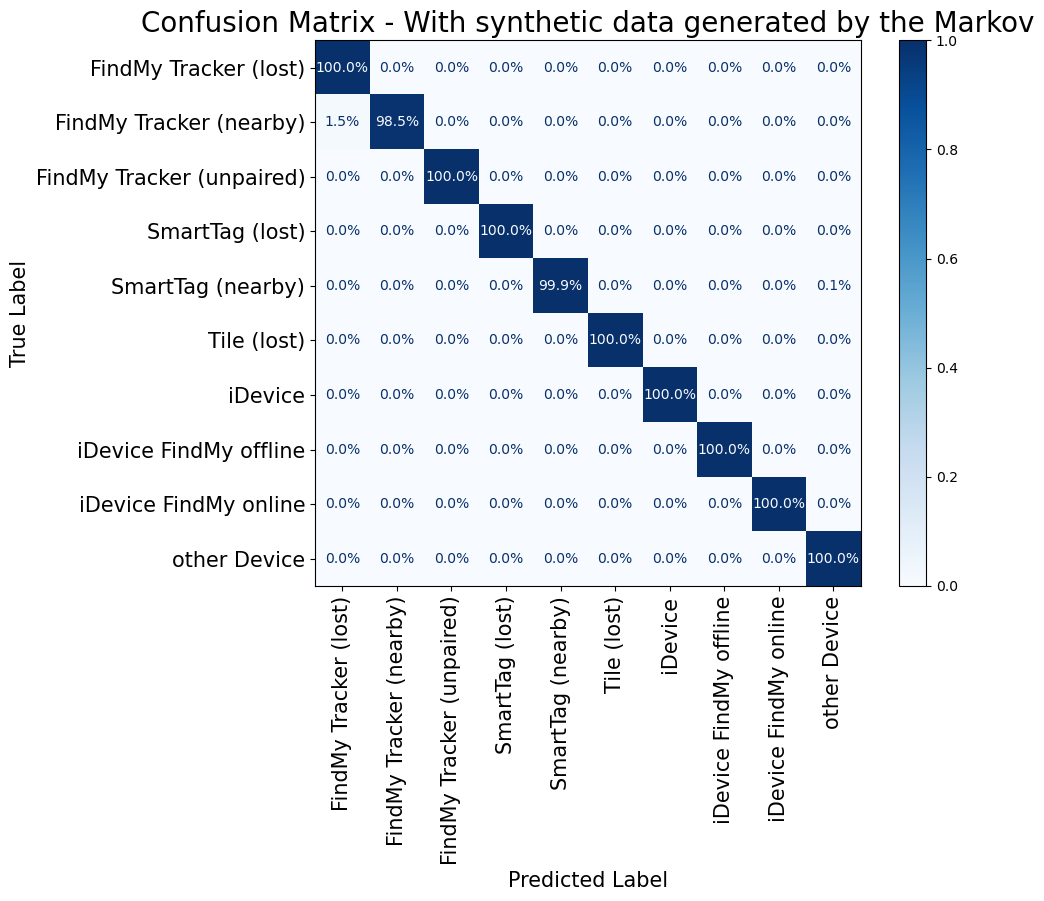

(MLPClassifier(early_stopping=True, random_state=0, validation_fraction=0.25,
               verbose=True),
 MinMaxScaler(),
 0.9984038599783119)

In [11]:
# @author:
#    Stefan Richard Saxer

evaluateModel(data_with_synthetic_data.copy(deep = True), saveName='With synthetic data generated by the Markov')

In [12]:
# @author:
#    Stefan Richard Saxer

import numpy as np
np.random.seed(0)

fractions = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1]
scores = []

for frac in fractions:
    print("Current Training Fraction: ", frac)
    
    X_train, X_test, y_train, y_test = splitDataset(data_with_synthetic_data.copy())
    X_train, X_test, scaler = scaleDataset(X_train, X_test)
    
    cutOff = int(frac*len(X_train))
    index = np.random.randint(0, len(X_train)-1, size = cutOff)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_train = X_train[index]
    y_train = y_train[index]
    
    model , score = trainModel(X_train, X_test, y_train, y_test, model=MLPClassifier(max_iter=200, verbose=False, random_state=0, tol=0.0001, early_stopping=True, validation_fraction=0.25), 
                                report=False, matrix=False)
    
    scores.append(score)

Current Training Fraction:  0.015625
Current Training Fraction:  0.03125
Current Training Fraction:  0.0625
Current Training Fraction:  0.125
Current Training Fraction:  0.25
Current Training Fraction:  0.5
Current Training Fraction:  1


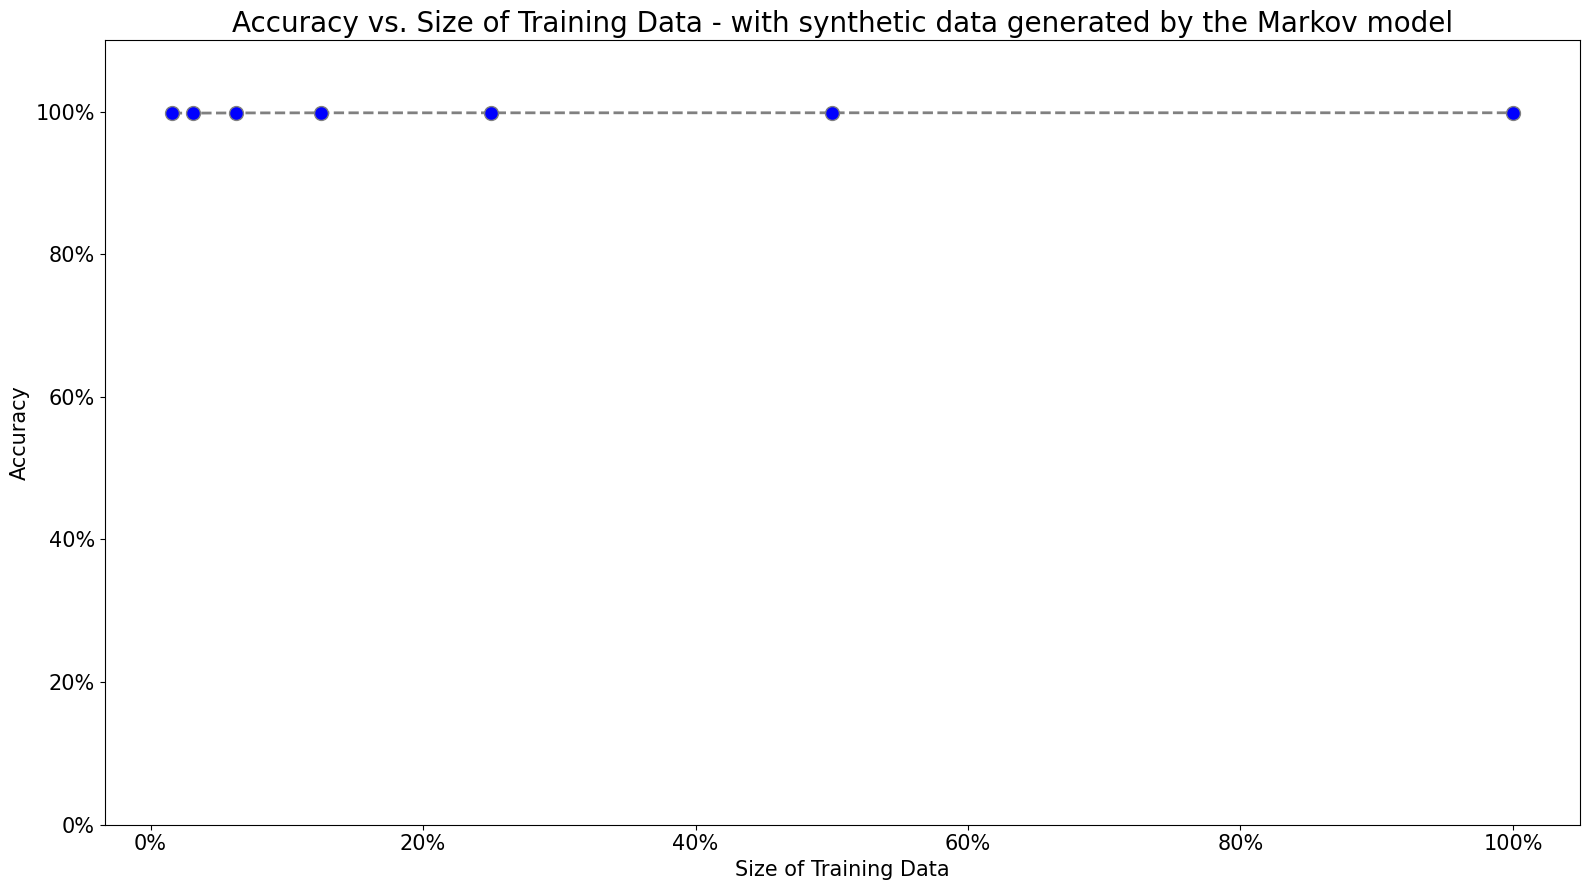

In [13]:
# @author:
#    Stefan Richard Saxer

from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(16, 9), dpi=100)
plt.plot(fractions, scores, ls="--", marker="o", color='grey', markerfacecolor="blue", markersize=10, lw=2)
title = "Accuracy vs. Size of Training Data - with synthetic data generated by the Markov model"
plt.title(title, fontsize=20)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("Size of Training Data", fontsize=15)
plt.ylim(bottom = 0, top = 1.1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig("../evaluation/training_data_size/" + title + ".png", dpi = 300)
plt.show()